In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.0f}'.format

# Gathering data

In [2]:
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Gathering the second dataset which contains image predictions using requests library

In [4]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url)
if response.status_code==200:
    with open('image-predictions.tsv','wb') as file:
        file.write(response.content)
    print('file downloaded successfuly')    
else:
    print('error downloading the file')

file downloaded successfuly


In [5]:
img_predict=pd.read_csv('image-predictions.tsv',sep='\t')
img_predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0,True,collie,0,True,Shetland_sheepdog,0,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,1,True,miniature_pinscher,0,True,Rhodesian_ridgeback,0,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,1,True,malinois,0,True,bloodhound,0,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0,True,redbone,0,True,miniature_pinscher,0,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,1,True,Rottweiler,0,True,Doberman,0,True


### The twitter archive dataset is missing some data like retweet count and like count, so i will get this data using twitter api

In [ ]:
# the following confidential data has been replaced by generic strings
consumer_key = 'CONSUMER_KEY'
consumer_secret = 'CONSUMER_SECRET'
access_token = 'ACCESS_TOKEN'
access_secret = 'ACCESS_SECRET'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
# keep track of tweets that have been deleted
failed_tweet = []
with open('tweet-json.txt', mode='w', encoding='utf-8') as file:
    for tweet_id in archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            tweet_json = json.dumps(tweet._json)
            # write tweet JSON data line by line
            file.write(tweet_json + '\n')
        except:
            failed_tweet.append(tweet_id)

In [8]:
tweets= []
with open('tweet-json.txt', mode='r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
        data = json.loads(line)
        tweet_id = data['id']
        favorite_count = data['favorite_count']
        retweet_count = data['retweet_count']
        tweets.append({'tweet_id': tweet_id, 'retweet_count': retweet_count, 'favorite_count': favorite_count})
tweet_data = pd.DataFrame(tweets, columns=['tweet_id', 'retweet_count', 'favorite_count'])
tweet_data.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


# Assesing data

### Visual assesment

## Archive
#### 1- There are wrong values in the "name" column ex:( "a","None") 
#### 2- Columns (doggo, floofer, pupper, puppo) should be in one column that represents the stage of the dog
#### 3- "source" column has wrong formated data

In [9]:
img_predict

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0,True,collie,0,True,Shetland_sheepdog,0,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,1,True,miniature_pinscher,0,True,Rhodesian_ridgeback,0,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,1,True,malinois,0,True,bloodhound,0,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0,True,redbone,0,True,miniature_pinscher,0,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,1,True,Rottweiler,0,True,Doberman,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,1,True,English_springer,0,True,German_short-haired_pointer,0,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0,False,Labrador_retriever,0,True,spatula,0,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,1,True,malamute,0,True,kelpie,0,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0,True,Pekinese,0,True,papillon,0,True


## Img_predict
#### 1- Not all the values in the columns (p1, p2, p3) are capitalized consistently
#### 2- (p1,p2,p3) columns: some values are separated by "_" and others are separated by spaces(tabs)

In [10]:
tweet_data

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


## tweet_data
#### There are no issues in this dataset that is concluded from my visual assesment

### Programmatic assessment

In [11]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2356,78,78,181,181,2356,2356
mean,742771590321692416,745507917855750784,20141706360873220,772039961038007040,12416983653017598,13,10
std,68567047444761000,75824920044192880,125279666255236304,62369278105055600,95992535331517504,46,7
min,666020888022790144,665814696700723200,11856342,666104133288665088,783214,0,0
25%,678398938214475776,675741911993464832,308637449,718631497683582976,4196983835,10,10
50%,719627934716235776,703870840226598912,4196983835,780465709297995776,4196983835,11,10
75%,799337304954252288,825780371286566912,4196983835,820314633777061888,4196983835,12,10
max,892420643555336192,886266357075128320,840547864354918400,887473957103951872,787461778435289088,1776,170


##### checking for incorrect names

In [13]:
archive['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

##### Checking for duplicates and null values

In [14]:
archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [15]:
archive.duplicated().any()

False

##### Checking data types

In [16]:
archive.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

## Archive
##### 1- The columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) have lots of missing values, this indicates that the number of retweets and replies is relatively low compared to original ratings tweets.
##### 
##### 2- There are extreme outliers in (rating_numerator, rating_denominator) columns as most ratings are around (10 to 12) in the "rating_numerator" column ,and 10 in the "rating_denominator" column , however their are values like "1776" in the numerator column , and "170" in the denominator column.
#####  
##### 3- Data Types: Columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id ) should be converted to string(object) to ensure no arithmetic operations are performed on them. Columns (retweeted_status_timestamp, timestamp) should be convered to datetime format to be easier to analyze them with datetime functions


In [17]:
img_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [18]:
img_predict.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2075,2075,2075,2075,2075
mean,738451357852529152,1,1,0,0
std,67852033330235664,1,0,0,0
min,666020888022790144,1,0,0,0
25%,676483507139540992,1,0,0,0
50%,711998809858043904,1,1,0,0
75%,793203448525178880,1,1,0,0
max,892420643555336192,4,1,0,0


##### Checking for duplicates and null values

In [19]:
img_predict.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [20]:
img_predict.duplicated().any()

False

##### Checking data types

In [21]:
img_predict.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

## Img_predict
##### 1- "tweet_id" column should be converted to string(object) to ensure no arthimetic operations are performed on it
##### 
##### 2- The mean of first prediction is "1" which higher than the second and third predictions, which suggests that the first prediction is more reliable

In [22]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [23]:
tweet_data.describe()

,tweet_id,retweet_count,favorite_count
count,2354,2354,2354
mean,742697816435036160,3165,8081
std,68528120712910672,5285,11815
min,666020888022790144,0,0
25%,678397510244808704,624,1415
50%,719459571111233536,1474,3604
75%,799305849241918464,3652,10122
max,892420643555336192,79515,132810


##### Checking for duplicates and null values

In [24]:
tweet_data.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [25]:
tweet_data.duplicated().any()

False

##### Checking data types

In [26]:
tweet_data.dtypes

tweet_id          int64
retweet_count     int64
favorite_count    int64
dtype: object

## tweet_data
##### 1- "tweet_id" column should be converted to string(object) to ensure no arthimetic operations are performed on it
##### 
##### 2- There is a wide variation in the retweet and favorite counts, as the standard deviation is very high


# Cleaning Data

##### Making a copy of data 

In [27]:
archive_cleaning=archive.copy()
img_predict_cleaning=img_predict.copy()
tweet_data_cleaning=tweet_data.copy()

# Archive

## Define
##### adding a column that represents rating in a ratio format

## Code

In [37]:
archive_cleaning['rating_ratio']=archive_cleaning['rating_numerator']/archive_cleaning['rating_denominator']

## Test

In [40]:
archive_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 6802
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2319 non-null   int64  
 1   timestamp           2319 non-null   object 
 2   source              2319 non-null   object 
 3   text                2319 non-null   object 
 4   rating_numerator    2319 non-null   int64  
 5   rating_denominator  2319 non-null   int64  
 6   name                2319 non-null   object 
 7   stage               2319 non-null   object 
 8   rating_ratio        2319 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 181.2+ KB


## Define
##### Filtereing archive dataset to include only tweets that have dog ratings (not retweets or replies)

## Code

In [28]:
archive_cleaning=archive_cleaning[(archive_cleaning['retweeted_status_id'].isnull())&(archive_cleaning['in_reply_to_status_id'].isnull())]
archive_cleaning.drop(['expanded_urls','retweeted_status_timestamp','retweeted_status_user_id','retweeted_status_id','in_reply_to_user_id','in_reply_to_status_id'],axis=1,inplace=True) #I removed these columns because they are useless now 

## Test

In [29]:
archive_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   rating_numerator    2097 non-null   int64 
 5   rating_denominator  2097 non-null   int64 
 6   name                2097 non-null   object
 7   doggo               2097 non-null   object
 8   floofer             2097 non-null   object
 9   pupper              2097 non-null   object
 10  puppo               2097 non-null   object
dtypes: int64(3), object(8)
memory usage: 196.6+ KB


## Define
##### dealing with unsuitable names

## Code

In [30]:

archive_cleaning = archive_cleaning[archive_cleaning['name'].str.istitle()] #from my assesment I concluded that most of the invalid names start with a small letter, but the correct names start with a capital letter (the istitle method gets all the values that start with capital letter) 
archive_cleaning['name'].replace('None', 'No Name', inplace=True) #the value 'None' does not obey to our role so i handled it in a different way


## Test

In [31]:
archive_cleaning['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'No Name',
       'Jax', 'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart',
       'Oliver', 'Jim', 'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'Canela',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven',
       'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante',
       'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash',
       'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie',
       'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha',
       'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jersey', 'Hob

## Define
##### Merging (doggo, floofer, pupper, puppo) into one column that represents the stage of the dog

## Code

In [32]:
archive_cleaning = pd.melt(
    archive_cleaning,
    id_vars=['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator', 'rating_denominator', 'name'],
    value_vars=['doggo', 'floofer', 'pupper', 'puppo'],
    var_name='stage',
    value_name='stage_text'
)

In [33]:
archive_cleaning.loc[archive_cleaning['stage_text'] == 'None', 'stage_text'] = 'unspecified'
archive_cleaning['stage'] = archive_cleaning['stage_text']
archive_cleaning.drop('stage_text', axis=1, inplace=True)

In [36]:
archive_cleaning.duplicated().any()

In [ ]:
archive_cleaning.drop_duplicates(inplace=True)

In [33]:
archive_cleaning['stage'].value_counts()

unspecified    7616
pupper          218
doggo            80
puppo            24
floofer          10
Name: stage, dtype: int64

## Test

In [41]:
archive_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 6802
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2319 non-null   int64  
 1   timestamp           2319 non-null   object 
 2   source              2319 non-null   object 
 3   text                2319 non-null   object 
 4   rating_numerator    2319 non-null   int64  
 5   rating_denominator  2319 non-null   int64  
 6   name                2319 non-null   object 
 7   stage               2319 non-null   object 
 8   rating_ratio        2319 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 181.2+ KB


## Define
##### changing source column to another form that can help us in our analysis

## Code

In [35]:
archive_cleaning['source'].unique() #inspecting the unique values in the column

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [36]:
def clean_source_column(source):
    if 'Twitter for iPhone' in source:
        return 'iPhone'
    elif 'Twitter Web Client' in source:
        return 'Web'
    elif 'Vine - Make a Scene' in source:
            return 'Vine'
    elif 'TweetDeck' in source:
        return 'TweetDeck'
    else:
        return 'Other'

In [37]:
archive_cleaning['source'] = archive_cleaning['source'].apply(clean_source_column)

## Test

In [38]:
archive_cleaning['source'].unique()

array(['iPhone', 'Web', 'Vine', 'TweetDeck'], dtype=object)

## Define
##### removing outliers in the rating numerator and denominator columns

## Code

In [39]:
def identify_outliers(df, column_names):
    for column_name in column_names:
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df


In [40]:
archive_cleaning=identify_outliers(archive_cleaning,['rating_numerator','rating_denominator'])

## Test

In [41]:
archive_cleaning[['rating_denominator','rating_numerator']].describe() # as we the outliers are removed

,rating_denominator,rating_numerator
count,7452,7452
mean,10,11
std,0,2
min,10,7
25%,10,10
50%,10,11
75%,10,12
max,10,14


## Define
##### converting ''timestamp'' column to datetime format, and tweet_id to string(object) data type

## Code

In [42]:
archive_cleaning['timestamp']=pd.to_datetime(archive_cleaning.timestamp)
archive_cleaning['tweet_id']=archive_cleaning['tweet_id'].astype('object')

## Test

In [43]:
archive_cleaning.dtypes

tweet_id                           object
timestamp             datetime64[ns, UTC]
source                             object
text                               object
rating_numerator                    int64
rating_denominator                  int64
name                               object
stage                              object
dtype: object

# Img_predict

## Define
##### Filtereing img_predict dataset to include only tweets that have ids that match ids in the archive datset (original rating tweets)

## Code

In [44]:
img_predict_cleaning=img_predict_cleaning[img_predict_cleaning['tweet_id'].isin(archive_cleaning['tweet_id'])]

## Test

In [45]:
img_predict_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1744 non-null   int64  
 1   jpg_url   1744 non-null   object 
 2   img_num   1744 non-null   int64  
 3   p1        1744 non-null   object 
 4   p1_conf   1744 non-null   float64
 5   p1_dog    1744 non-null   bool   
 6   p2        1744 non-null   object 
 7   p2_conf   1744 non-null   float64
 8   p2_dog    1744 non-null   bool   
 9   p3        1744 non-null   object 
 10  p3_conf   1744 non-null   float64
 11  p3_dog    1744 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 141.4+ KB


## Define
##### Dealing with the inconsistent capitalization in p1,p2, and p3 columns

## Code

In [46]:
img_predict_cleaning['p1'] = img_predict_cleaning['p1'].str.capitalize()
img_predict_cleaning['p2'] = img_predict_cleaning['p2'].str.capitalize()
img_predict_cleaning['p3'] = img_predict_cleaning['p3'].str.capitalize()

## Test

In [47]:
img_predict_cleaning[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,Welsh_springer_spaniel,Collie,Shetland_sheepdog
11,Gordon_setter,Yorkshire_terrier,Pekinese
12,Walker_hound,English_foxhound,Ibizan_hound
14,Bloodhound,German_shepherd,Malinois
15,Lhasa,Shih-tzu,Dandie_dinmont


## Define
##### Dealing with the difference in delimiters

## Code

In [48]:
img_predict_cleaning['p1'] = img_predict_cleaning['p1'].str.replace('_',' ')
img_predict_cleaning['p2'] = img_predict_cleaning['p2'].str.replace('_',' ')
img_predict_cleaning['p3'] = img_predict_cleaning['p3'].str.replace('_',' ')

## Test

In [49]:
img_predict_cleaning[['p1', 'p2', 'p3']].head()

,p1,p2,p3
0,Welsh springer spaniel,Collie,Shetland sheepdog
11,Gordon setter,Yorkshire terrier,Pekinese
12,Walker hound,English foxhound,Ibizan hound
14,Bloodhound,German shepherd,Malinois
15,Lhasa,Shih-tzu,Dandie dinmont


## Define
##### Converting tweet_id to string(object) data type

## Code

In [50]:
img_predict_cleaning['tweet_id']=img_predict_cleaning['tweet_id'].astype('object')

## Test

In [51]:
img_predict_cleaning.dtypes

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

# tweet_data

## Define
##### Filtereing tweet_data dataset to include only tweets that have ids that match ids in the archive datset (original rating tweets)

## Code

In [52]:
    tweet_data_cleaning=tweet_data_cleaning[tweet_data_cleaning['tweet_id'].isin(archive_cleaning['tweet_id'])]

## Test

In [53]:
tweet_data_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        1863 non-null   int64
 1   retweet_count   1863 non-null   int64
 2   favorite_count  1863 non-null   int64
dtypes: int64(3)
memory usage: 58.2 KB


## Define
##### Converting tweet_id to string(object) data type

## Code

In [54]:
tweet_data_cleaning['tweet_id']=tweet_data_cleaning['tweet_id'].astype('object')

## Test

In [55]:
tweet_data_cleaning.dtypes

tweet_id          object
retweet_count      int64
favorite_count     int64
dtype: object

# Storing data

In [56]:
master_dataset=pd.merge(archive_cleaning,img_predict_cleaning,on='tweet_id',how='inner')
master_dataset=pd.merge(master_dataset,tweet_data_cleaning,on='tweet_id',how='inner')

In [57]:
master_dataset.to_csv('twitter_archive_master.csv',index=False)
master_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6976 entries, 0 to 6975
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            6976 non-null   object             
 1   timestamp           6976 non-null   datetime64[ns, UTC]
 2   source              6976 non-null   object             
 3   text                6976 non-null   object             
 4   rating_numerator    6976 non-null   int64              
 5   rating_denominator  6976 non-null   int64              
 6   name                6976 non-null   object             
 7   stage               6976 non-null   object             
 8   jpg_url             6976 non-null   object             
 9   img_num             6976 non-null   int64              
 10  p1                  6976 non-null   object             
 11  p1_conf             6976 non-null   float64            
 12  p1_dog              6976 non-null 

# Exploratory data analysis

### What is the most used source to tweet on We Rate Dogs?

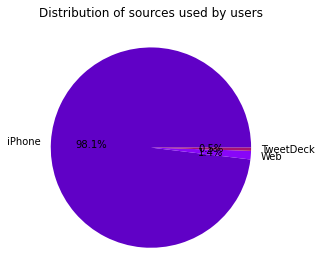

In [58]:
master_dataset['source'].value_counts().plot(kind='pie',autopct='%1.1f%%',colors=sns.color_palette('gnuplot'))
plt.title('Distribution of sources used by users')
plt.axis('off')
plt.tight_layout()

##### Iphone is most used software by users interested in WeRateDogs content

### How the posting frequency of WeRateDogs changed years?

Text(0, 0.5, 'Number of tweets')

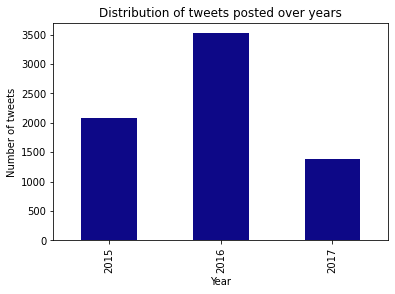

In [62]:
year=master_dataset['timestamp'].dt.year
master_dataset.groupby(year)['tweet_id'].count().plot(kind='bar',colormap='plasma')
plt.title('Distribution of tweets posted over years')
plt.xlabel('Year')
plt.ylabel('Number of tweets')

##### There was an increase in the posting frequency from 2015 to 2016, but there was a huge drop in th eposting frequency from 2016 to 2017

### How the number of favorites (likes) that WeRateDogs got changed over time?

([<matplotlib.axis.XTick at 0x29f4b0136d0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

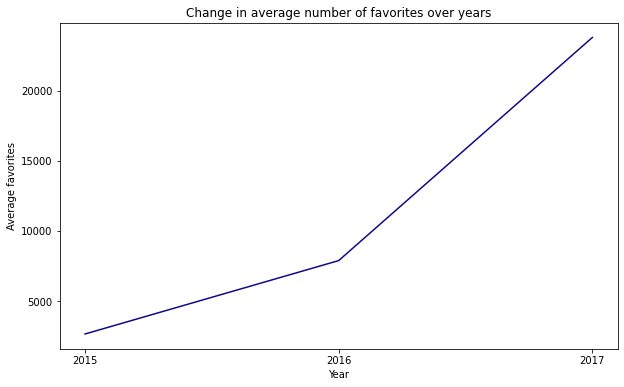

In [60]:
favorites_per_year = master_dataset.groupby(year)['favorite_count'].mean()
favorites_per_year.plot(kind='line',colormap='plasma',figsize=(10,6))
plt.title('Change in average number of favorites over years')
plt.xlabel('Year')
plt.ylabel('Average favorites')
plt.xticks(favorites_per_year.index) # this line is because there was a problem in the way of representation of the years on x-axis 

##### The number of favorites inceased alot from 2015 to 2017, this tells us that the latest content from WeRateDogs is more preferable for users

### Is there a relation between the length of tweet text and the number of favorites and retweets?

In [61]:
master_dataset['text_length'] = master_dataset['text'].str.len()
relation_retweets = master_dataset['text_length'].corr(master_dataset['retweet_count'])
relation_favorites = master_dataset['text_length'].corr(master_dataset['favorite_count'])
print(f"Correlation between tweet length and retweet count: {relation_retweets}")
print(f"Correlation between tweet length and favorite count: {relation_favorites}")

Correlation between tweet length and retweet count: 0.051435377646321244
Correlation between tweet length and favorite count: 0.16259918529814454


##### There is very weak positive relation between tweet length and retweet count, but there is a stronger positive relation between tweet length and favorite count. This indicates that some people prefer longer tweet text

Text(0, 0.5, 'Retweet Count')

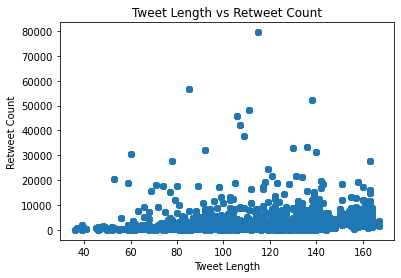

In [62]:
plt.scatter(x='text_length', y='retweet_count', data=master_dataset)
plt.title('Tweet Length vs Retweet Count')
plt.xlabel('Tweet Length')
plt.ylabel('Retweet Count')

Text(0, 0.5, 'Retweet Count')

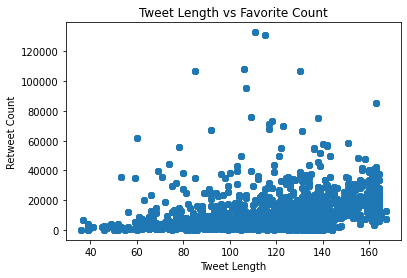

In [157]:
plt.scatter(x='text_length', y='favorite_count', data=master_dataset)
plt.title('Tweet Length vs Favorite Count')
plt.xlabel('Tweet Length')
plt.ylabel('Retweet Count')